In [52]:
from pathlib import Path
from itertools import product
import pandas as pd

In [53]:
methods = ['maml', 'protonet', 'matchingnet', 'baseline', 'baseline_pp', 'relationnet']
datasets = ['tabula_muris', 'swissprot']
n_shots = [1, 5, 10]
n_ways = [5, 20]

results = []

In [54]:
# Write a function to extract the train, test and val accuracies from the log file
""" E.g. Time: 20231210-124517, Setting: swissprot-train-FCNet-protonet 5shot 5way, Acc: 89.03% +- 0.68%, Model: checkpoints/protonet_swissprot_5_5/swissprot/protonet_FCNet/20231210_124157/best_model.tar 
Time: 20231210-124602, Setting: swissprot-val-FCNet-protonet 5shot 5way, Acc: 70.02% +- 0.82%, Model: checkpoints/protonet_swissprot_5_5/swissprot/protonet_FCNet/20231210_124157/best_model.tar 
Time: 20231210-124640, Setting: swissprot-test-FCNet-protonet 5shot 5way, Acc: 62.69% +- 0.60%, Model: checkpoints/protonet_swissprot_5_5/swissprot/protonet_FCNet/20231210_124157/best_model.tar """

def extract_accs(results_file):
    with open(results_file, 'r') as f:
        lines = f.readlines()
    train, train_unc = extract_accs_from_line(lines[-3])
    val, val_unc = extract_accs_from_line(lines[-2])
    test, test_unc = extract_accs_from_line(lines[-1])
    return train, train_unc, val, val_unc, test, test_unc

def extract_accs_from_line(line):
    acc = float(line.split(' ')[-6].split('%')[0])
    acc_unc = float(line.split(' ')[-4].split('%')[0])
    return acc, acc_unc

assert extract_accs('../../checkpoints/protonet_swissprot_5_5/results.txt') == (89.03, 0.68, 70.02, 0.82, 62.69, 0.6)


In [55]:
root = Path('../../checkpoints/')
for method, dataset, n_shot, n_way in product(methods, datasets, n_shots, n_ways):
    path = root.joinpath(f'{method}_{dataset}_{n_shot}_{n_way}')
    try:
        train, train_unc, val, val_unc, test, test_unc = extract_accs(path.joinpath('results.txt'))
        results.append({
            'method': method, 
            'dataset': dataset, 
            'n_shots': n_shot, 
            'n_ways': n_way, 
            'train': train, 
            'train_unc': train_unc, 
            'val': val, 
            'val_unc': val_unc, 
            'test': test, 
            'test_unc': test_unc
        })
    except:
        results.append({
            'method': method, 
            'dataset': dataset, 
            'n_shots': n_shot, 
            'n_ways': n_way, 
        })

In [56]:
df = pd.DataFrame(results)
df.to_csv('baselines.csv')
df.to_csv('../../../report/tables/baselines.csv')

In [57]:
df[df['n_shots'] == 5][['method', 'dataset', 'test', 'test_unc', 'n_ways']]

,method,dataset,test,test_unc,n_ways
2,maml,tabula_muris,86.19,0.66,5
3,maml,tabula_muris,7.60,0.19,20
8,maml,swissprot,43.50,0.64,5
9,maml,swissprot,NaN,NaN,20
14,protonet,tabula_muris,89.55,0.59,5
15,protonet,tabula_muris,71.59,0.37,20
20,protonet,swissprot,62.69,0.60,5
21,protonet,swissprot,56.01,0.41,20
26,matchingnet,tabula_muris,84.36,0.76,5
27,matchingnet,tabula_muris,60.23,0.41,20


In [58]:
# FInd max test accuracy for each dataset
df.groupby('dataset')['test'].max()

dataset
swissprot       75.33
tabula_muris    92.00
Name: test, dtype: float64

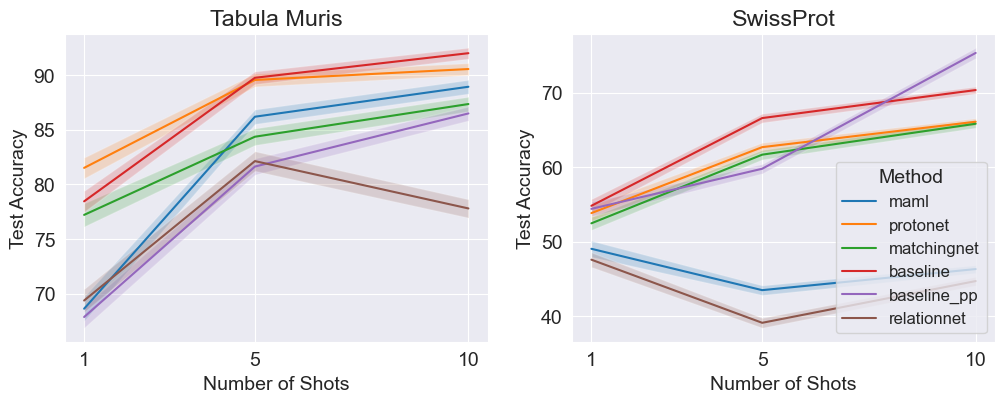

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
sns.set_style("darkgrid")

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

tabula_5way = df[(df['dataset'] == 'tabula_muris') & (df['n_ways'] == 5)]
swissprot_5way = df[(df['dataset'] == 'swissprot') & (df['n_ways'] == 5)]

axs[0] = sns.lineplot(x='n_shots', y='test', hue='method', data=tabula_5way, errorbar=None, ax=axs[0])
axs[0].set_ylabel('Test Accuracy')
axs[0].set_xlabel('Number of Shots')
axs[0].set_title('Tabula Muris')
axs[0].set_xticks([1,5,10])
axs[0].get_legend().remove()

axs[1] = sns.lineplot(x='n_shots', y='test', hue='method', data=swissprot_5way, errorbar=None, ax=axs[1])
axs[1].set_ylabel('Test Accuracy')
axs[1].set_xlabel('Number of Shots')
axs[1].set_title('SwissProt')
axs[1].set_xticks([1,5,10])
axs[1].legend(loc='lower right', title='Method', prop={'size': 12})

for method in methods:
    method_df = tabula_5way[tabula_5way['method'] == method]
    axs[0].fill_between([1,5,10], method_df['test'] - method_df['test_unc'], method_df['test'] + method_df['test_unc'], alpha=0.2)
    method_df = swissprot_5way[swissprot_5way['method'] == method]
    axs[1].fill_between([1,5,10], method_df['test'] - method_df['test_unc'], method_df['test'] + method_df['test_unc'], alpha=0.2)

plt.savefig('../../../report/figures/nshot.png', bbox_inches='tight')
plt.show()